In [24]:
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import numpy as np
from matplotlib import pyplot as plt
import math
import random

In [25]:
# compute each hinge loss and the average
def loss_function(x, y, w):
    losses = (1 - y * np.dot(x, w))
    hinge_loss = 0
    for one_loss in losses:
        hinge_loss += max(0, one_loss)
    return hinge_loss / len(x)

In [26]:
# compute each gradient and average
def compute_gradient(x, y, w):
    gradient = np.zeros((1, x.shape[1]))
    losses = (1 - y * np.dot(x, w))
    for i, loss in enumerate(losses):
        if loss <= 0:
            gradient += w.T
        else:
            gradient += w.T - y[i] * x[i]
    return gradient / len(x)

In [27]:
# NAG update parameters
def NAG(w, gradient, v, mu=0.9, eta=0.001):
    v_prev = v
    v = mu * v - eta * gradient
    w += (-mu * v_prev + (1 + mu) * v).reshape((123, 1))
    return w, v

# RMSProp update parameters
def RMSProp(w, gradient, cache, decay_rate=0.9, eps=1e-8, eta=0.001):
    cache = decay_rate * cache + (1 - decay_rate) * (gradient ** 2)
    w += (- eta * rmsprop_gradient / (np.sqrt(cache) + eps)).reshape((123, 1))
    return w, cache

# AdaDelta update parameters
def AdaDelta(w, gradient, cache, delta_t, r=0.95, eps=1e-6):
    cache = r * cache + (1 - r) * (gradient ** 2)
    delta_theta = - np.sqrt(delta_t + eps) / np.sqrt(cache + eps) * gradient
    w = w + delta_theta.reshape((123, 1))
    delta_t = r * delta_t + (1 - r) * (delta_theta ** 2)
    return w, cache, delta_t

# Adam update parameters
def Adam(w, gradient, m, i, t, beta1=0.9, beta2=0.999, eta=0.001, eps=1e-8):
    m = beta1 * m + (1 - beta1) * gradient
    mt = m / (1 - beta1 ** i)
    t = beta2 * t + (1 - beta2) * (gradient ** 2)
    vt = t / (1 - beta2 ** i)
    w += (-eta * mt / (np.sqrt(vt) + eps)).reshape((123, 1))
    return w, m, t

In [28]:
# load train date
train_data = load_svmlight_file('H:/ML/experiment/a9a.txt')
x_train = np.reshape(train_data[0].todense().data, (train_data[0].shape[0], train_data[0].shape[1]))
y_train = np.reshape(train_data[1].data, (train_data[1].shape[0], 1))
y_train = (y_train + 1) / 2

#load test data
test_data = load_svmlight_file('H:/ML/experiment/a9a.t')
zeros = np.zeros(test_data[0].shape[0])
x_valid = np.reshape(test_data[0].todense().data, (test_data[0].shape[0], test_data[0].shape[1]))
x_valid = np.column_stack((x_valid, zeros))
y_valid = np.reshape(test_data[1].data, (test_data[1].shape[0], 1))
y_valid = (y_valid + 1) / 2

In [29]:
max_epoch = 201
batch_size = 5000

# initial each w to zero
nag_w = np.zeros((x_train.shape[1], 1))
rmsprop_w = np.zeros((x_train.shape[1], 1))
adadelta_w = np.zeros((x_train.shape[1], 1))
adam_w = np.zeros((x_train.shape[1], 1))

# some parameters used in the update process are initialized to zero
v = np.zeros(x_train.shape[1])
cache = np.zeros(x_train.shape[1])
adadelta_cache = np.zeros(x_train.shape[1])
delta_t = np.zeros(x_train.shape[1])
m = np.zeros(x_train.shape[1])
t = np.zeros(x_train.shape[1])

# recode the loss of each method 
nag_loss = []
rmsprop_loss = []
adadelta_loss = []
adam_loss = []

In [30]:
# update parameters
for i in range(1, max_epoch):
    index = list(range(len(x_train)))
    random.shuffle(index)

    # NAG update parameters
    nag_gradient = compute_gradient(x_train[index][:batch_size], y_train[index][:batch_size], nag_w)
    nag_w, v = NAG(nag_w, nag_gradient, v)
    nag_loss.append(loss_function(x_valid, y_valid, nag_w))

    # RMSprop update parameters
    rmsprop_gradient = compute_gradient(x_train[index][:batch_size], y_train[index][:batch_size], rmsprop_w)
    rmsprop_w, cache = RMSProp(rmsprop_w, rmsprop_gradient, cache)
    rmsprop_loss.append(loss_function(x_valid, y_valid, rmsprop_w))

    # AdaDelta update parameters
    adadelta_gradient = compute_gradient(x_train[index][:batch_size], y_train[index][:batch_size], adadelta_w)
    adadelta_w, adadelta_cache, delta_t = AdaDelta(adadelta_w, adadelta_gradient,
                                                   adadelta_cache, delta_t)
    adadelta_loss.append(loss_function(x_valid, y_valid, adadelta_w))

    # Adam update parameters
    adam_gradient = compute_gradient(x_train[index][:batch_size], y_train[index][:batch_size], adam_w)
    adam_w, m, t = Adam(adam_w, adam_gradient, m, i, t)
    adam_loss.append(loss_function(x_valid, y_valid, adam_w))

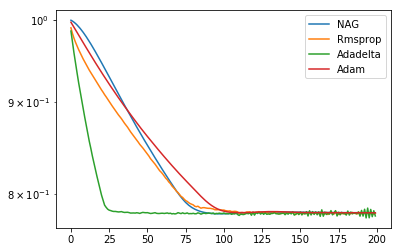

In [31]:
# draw loss-epoch curve
plt.plot(nag_loss, label='NAG')
plt.plot(rmsprop_loss, label='Rmsprop')
plt.plot(adadelta_loss, label='Adadelta')
plt.plot(adam_loss, label='Adam')
plt.yscale('log')
plt.legend()
plt.show()